#  <center> <font style="color:rgb(100,109,254)"> Watershed Algorithm </font> </center>


## <font style="color:rgb(134,19,348)">What is Watershed Algorithm: </font>

Watershed is a popular classic Image Segmentation Algorithm. You are already familiar with some segmentation techniques from basic image thresholding to Histogram back-projection, Grabcut, Color Segmentation, etc. Now all these approaches are fine and effective but with watershed you can even segment objects which are touching each other or overlapping.

##  <font style="color:rgb(134,19,348)"> How Watershed Algorithm Works: </font>

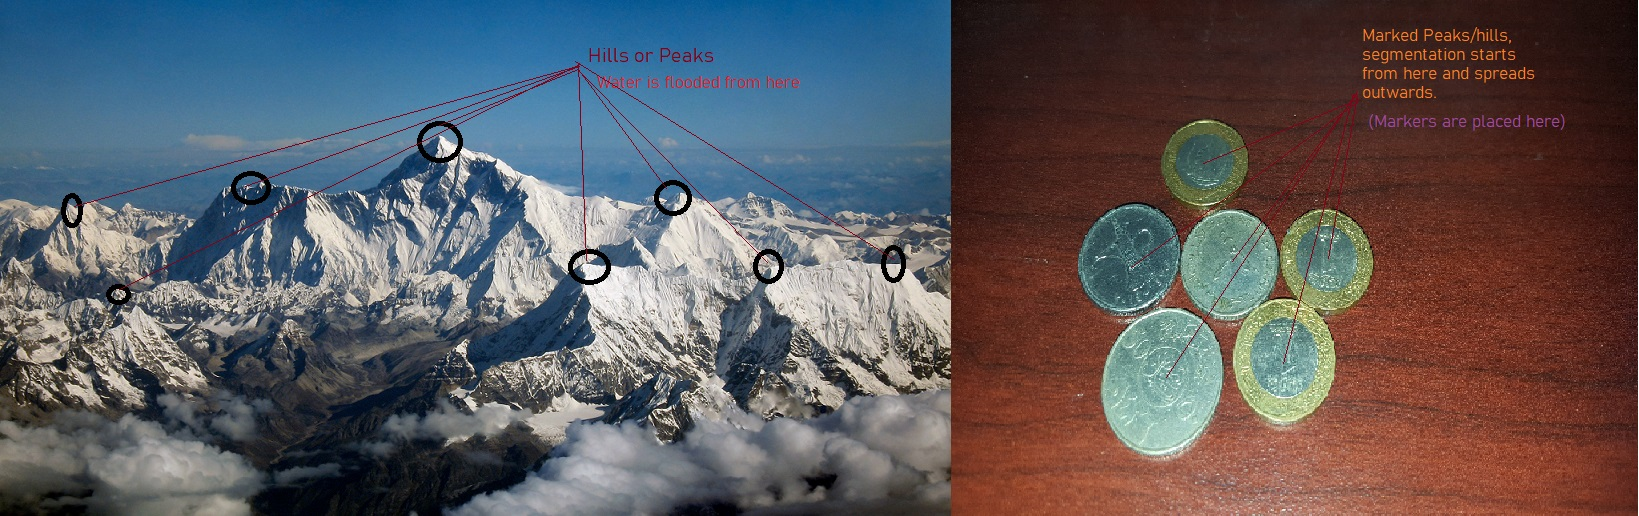

I'll give you a simple intuition of how watershed works, discussing it in detail is outside the scope of this notebook. Lets first recap what image segmentation is: In Image segmentation algorithms, the aim is to decide for each pixel where do they belong, meaning we have to distinguish between background and foreground pixels and even between individual object pixels.  

Here's how the classic Watershed approach works: 

We take a grayscale image, consider it as a topographic surface where the high intensity denotes peaks and hills and low intensity denotes valleys, Now you start flooding water (Filling these with marked labels to isolate them from others) from these peaks onto the valleys (local minimal for each object). Now before I elaborate on this, I would mention this approach gives over segmented results due to noise and irregularities in image. So instead We use **Marker Based Watershed Algorithm**, 

##  <font style="color:rgb(134,19,348)"> Marker Based Watershed Algorithm </font>
Here we start with user defined markers, these markers are starting points of segmentation for watershed for each object in image. The markers are either defined manually via point-and-clicks or either automatically determined using heuristics such as thresholding and morphological operations etc.
*e.g. The coins on a clean paper can be easily segmented and their centers can be used as markers)*

Now taking the same coin example, as discussed previously when we have placed markers, they start flooding, (i.e. labeling outer areas) these are called valleys. This may continue to happen until the valleys of different markers reaches each other's peak. 

### [Still confused, Here's another explanation on watershed with Animations](http://www.cmm.mines-paristech.fr/~beucher/wtshed.html#princip)

Now there is an implementation of watershed in Opencv but we will be using the watershed implementation in scikit-image as I feel its more intuitive, we will also be using `scipy` library so you can install these if you don't already have them.

```pip install scikit-image``` 

```pip install scipy```


## <font style="color:rgb(134,19,348)"> Watershed Implementation </font>

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed

### <font style="color:rgb(134,19,348)"> Step 1: Smooth the Image: </font>

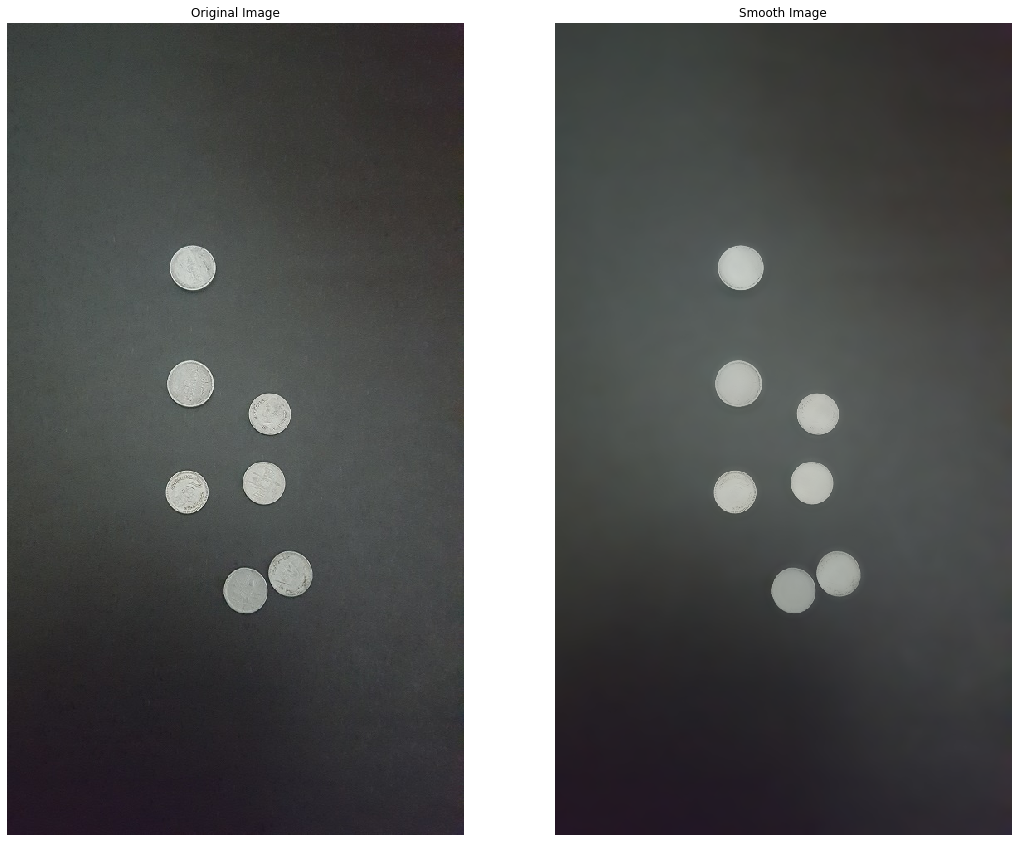

In [5]:
img = cv2.imread('media/M4/ncoin1.jpg')
orig = img.copy()

# This smoothes our image and removes noise
smoothed = cv2.bilateralFilter(img,19,150,100)

plt.figure(figsize=[18,18])
plt.subplot(121);plt.imshow(orig[:,:,::-1]);plt.title("Original Image");plt.axis('off');
plt.subplot(122);plt.imshow(smoothed[:,:,::-1],cmap='gray');plt.title("Smooth Image");plt.axis('off');

### <font style="color:rgb(134,19,348)">Step 2: Threshold The Image </font>

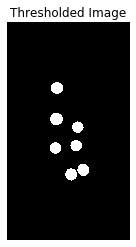

In [7]:
gray = cv2.cvtColor(smoothed,cv2.COLOR_BGR2GRAY)
_ , thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)  

plt.imshow(thresh[:,:],cmap='gray');plt.title("Thresholded Image");plt.axis('off');

### <font style="color:rgb(134,19,348)">Step 3:  Compute Distance Map </font>

We will now compute the exact Euclidean distance from every binary pixel to the nearest zero pixel meaning we will find the Euclidean distance to the closest zero (i.e., background pixel) for each of the foreground pixels. The pixel which are the farthest from background are the peaks.


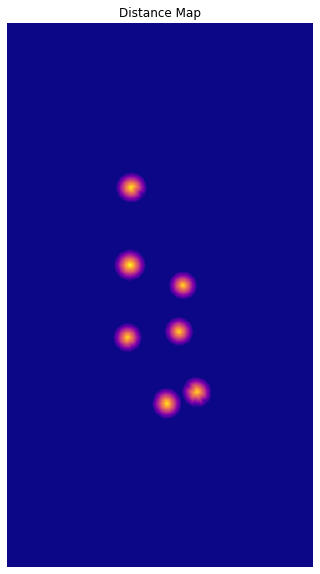

In [9]:
distance_map = ndimage.distance_transform_edt(thresh)

# Displayig in plasma colormap, Peaks are the brightest, as they are farthest from any background pixel.
plt.figure(figsize=[10,10])
plt.imshow(distance_map[:,:],cmap='plasma');plt.title("Distance Map");plt.axis('off');

### <font style="color:rgb(134,19,348)">Step 4: Find Peaks </font>
We will now use `peak_local_max()` to find peaks.

```peak_local_max(image, min_distance=1, indices=True)```

**This function Find peaks ( Peaks are the local maxima ) in an image as coordinate list or boolean mask.**

- **labels:** (ndarray of ints), If provided, each unique region labels == value represents a unique region to search for peaks. Zero is reserved for background.
- **indices** (bool), If True, the output will be an array representing peak coordinates. If False, the output will be a boolean array shaped as image.shape with peaks present at True elements.
- **min_distance:** (int), Minimum number of pixels separating peaks in a region of 2 * min_distance + 1 (i.e. peaks are separated by at least min_distance). To find the maximum number of peaks, use min_distance=1.

[**See All available params for this method here**](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max)

In [10]:
# Ensuring there is atleast a 8 pixel distance between each peak, you can change this value.
# We are also returning the result as the same shape as the input image.
localMax = peak_local_max(distance_map, indices=False, min_distance=8)
print("Total Peaks Detected: {}".format(sum(sum(localMax == True))))

Total Peaks Detected: 8


**See the number of detected peaks should match or at least be close to number of objects in our image**

The result of LocalMax looks something like below:

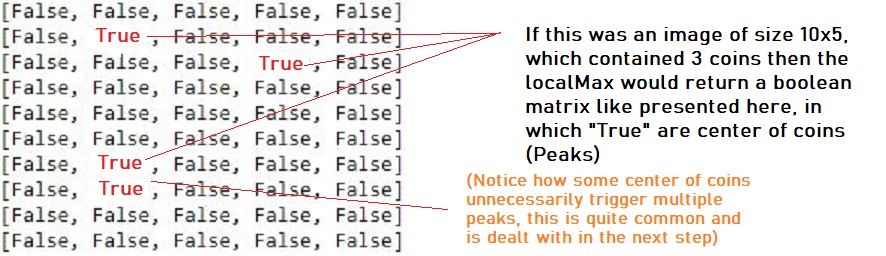

### <font style="color:rgb(134,19,348)">Step 5: Apply Connected Component Analysis (CCA) and labeling each peak separately. </font>
In the above step, a single object may have multiple peaks, in connected components analysis a kernel goes over the image and label connected peaks with the same labeled marker. Now each peak has a unique label, the background is labeled as 0.

```label, num_features = ndimage.label(input, structure=None)```

**Params:**

- **input:** An array-like object to be labeled. Any non-zero values in input are counted as features and zero values are considered the background.
- **structure:** A structuring element that defines feature connections. structure must be centrosymmetric. If no structuring element is provided, one is automatically generated with a squared connectivity equal to one.
- **labels:** An integer ndarray where each unique feature in input has a unique label in the returned array.
- **num_features:** How many objects were found.

 [Further details for this method are found here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html)

In [11]:
markers, _ = ndimage.label(localMax, structure=np.ones((3, 3)))
print("List of All markers: {} ".format(np.unique(markers)))

List of All markers: [0 1 2 3 4 5 6 7] 


**The output of the above function looks something like the following looks something like the following:**

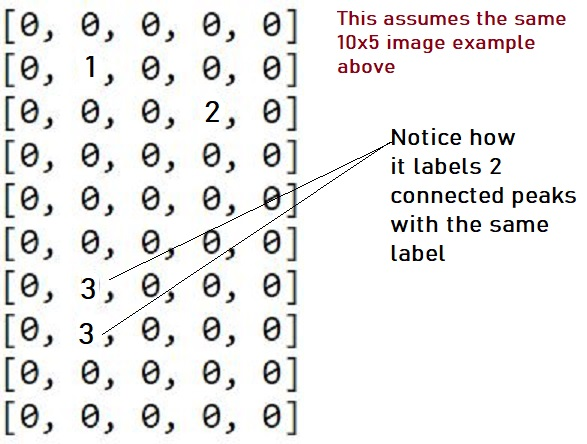

**Visualizing Markers**
You can visualize some markers with below code.

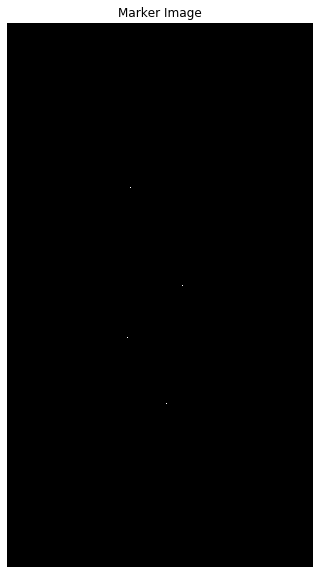

In [12]:
vismarkers = markers > 0 

plt.figure(figsize=[10,10])
plt.imshow(vismarkers.astype('uint8'),cmap='gray');plt.title("Marker Image");plt.axis('off');

### <font style="color:rgb(134,19,348)">Step 6: Apply Watershed </font>
Now that we have the markers we can apply the watershed algorithm.

[```labels = watershed(image, markers=None, mask=None)```](https://docs.opencv.org/4.2.0/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1)

**markers:** int, or ndarray of int, same shape as `image`,The desired number of markers, or an array marking the basins with the values to be assigned in the label matrix. Zero means not a marker. If None (no markers given), the local minima of the image are used as markers.

**mask:** ndarray of bools or 0s and 1s,Array of same shape as image. Only points at which mask == True will be labeled.

**image:** ndarray (2-D, 3-D) of integers, Data array where the lowest value points are labeled first.

[You can get more information on watershed from skimage lib here](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed)

In [13]:
# Watershed uses the marker and thresholding info.
labels = watershed(-distance_map, markers, mask=thresh)

# -1 because 0 represents background label
print("No of unique segments found: {}".format(len(np.unique(labels)) - 1))

No of unique segments found: 7


**Note:** *Since this watershed function requires that our markers represent local minima (valleys) but our markers are local Maxima (peaks) so we put the negative distance map inside the watershed function*


The watershed function will return a matrix of labels, a ndarray with the same width and height as our input image.
where each pixel value will get label value, pixels that have the same label value belong to the same object.

**The output of watershed function looks something like the following:**
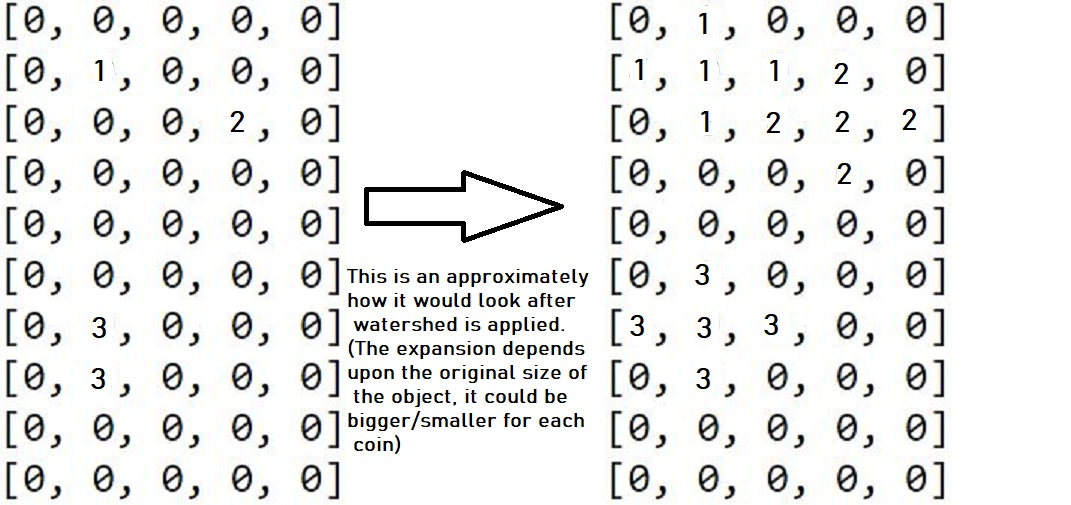

### <font style="color:rgb(134,19,348)">Step 7: Loop and Draw each Object:</font>
Now what we will do is pretty simple, for each label we will create an empty black image, and white color the part of the image that contains that label, then detect that object with contour detection (since it would already be white). Finally we will draw that contour. We will do this for each label (detected object).

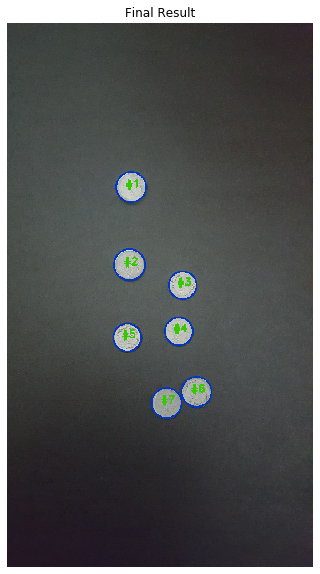

In [14]:
img = orig.copy()

# Start looping over each unique label
for label in np.unique(labels):
    
    # Ignore if label == 0 because its background.
    if label == 0:
        continue
    
    # Create a black image of same size as the image
    mask = np.zeros(gray.shape, dtype="uint8")
    # Turn the area white, wherever the target label appears
    mask[labels == label] = 255
    
    # Detect and grab the largest contour
    cnts,hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
 

    # Draw an enclosing circle around the contour, You can choose to draw a bounding box too.
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(img, (int(x), int(y)), int(r), (200, 55, 0), 2)
    cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 55), 2)

plt.figure(figsize=[10,10])
plt.imshow(img[:,:,::-1]);plt.title("Final Result");plt.axis('off');

### <font style="color:rgb(134,19,348)"> Full Function </font>
Here is a function which does all the above

In [15]:
def perform_watershed(img, vis=True):
    orig = img.copy()
    smoothed = cv2.bilateralFilter(img,23,150,100)
    
    gray = cv2.cvtColor(smoothed,cv2.COLOR_BGR2GRAY)
    _ , thresh = cv2.threshold(gray, 80, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    distance_map = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(distance_map, indices=False, min_distance=8)
    markers, _ = ndimage.label(localMax, structure=np.ones((3, 3)))
    labels = watershed(-distance_map, markers, mask=thresh)
    
    for label in np.unique(labels):

        if label == 0:
            continue

        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        cnts,hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        c = max(cnts, key=cv2.contourArea)

        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(img, (int(x), int(y)), int(r), (200, 55, 0), 2)
        cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 200, 55), 2)
    
    if vis:
       plt.figure(figsize=[15,15])
       plt.subplot(121);plt.imshow(orig[:,:,::-1]);plt.title("Original");plt.axis('off');
       plt.subplot(122); plt.imshow(img[:,:,::-1]);plt.title("Final Result");plt.axis('off');

    else:
       return img

### <font style="color:rgb(134,19,348)"> Test out Different Images below: </font>
Try images, ncoin2.jpg, ncoin3.jpg, ncoin4.jpg

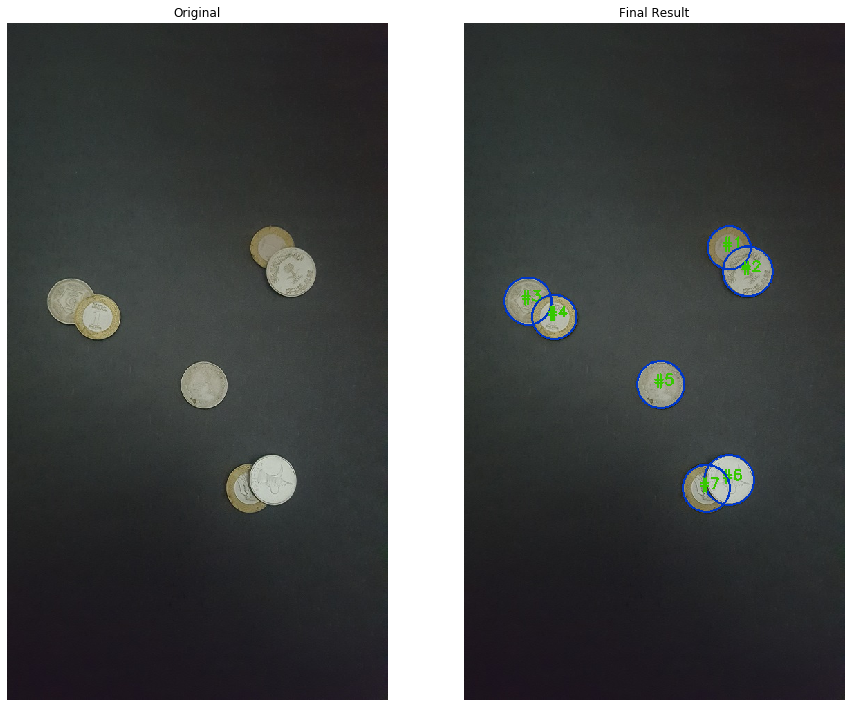

In [20]:
img = cv2.imread('media/M4/ncoin4.jpg')
perform_watershed(img)